# Определение тональности комментариев

# 1. Загрузка бибилиотек и данных

In [1]:
#pip install pymorphy2
# pip install pymorphy3
#pip install nltk
#pip install re
#pip install scikeras

In [2]:
import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

from string import punctuation

import pymorphy3

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback

import tensorflow as tf
from scikeras.wrappers import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def creat_df():
    data_list = []
    with open("dataset.txt", encoding = 'utf-8') as file:
        for line in file:
            labels = line.split()[0]
            text = line[len(labels)+1:].strip()
            labels = labels.split(",")
            mask = [1 if "__label__NORMAL" in labels else 0,
                    1 if "__label__INSULT" in labels else 0,
                    1 if "__label__THREAT" in labels else 0,
                    1 if "__label__OBSCENITY" in labels else 0]
            data_list.append((text, *mask))
    return pd.DataFrame(data_list, columns=["comment", "normal", "insult", "threat", "obscenity"])

In [4]:
df = creat_df()
df

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [5]:
df2 = pd.read_csv('labeled.csv')
df2

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Датасеты созданы под разные семантические задачи, так что будем обучать две модели, одну для тональности, другу просто для классификации токсичности

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    248290 non-null  object
 1   normal     248290 non-null  int64 
 2   insult     248290 non-null  int64 
 3   threat     248290 non-null  int64 
 4   obscenity  248290 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [8]:
df.duplicated().sum()

np.int64(6)

In [9]:
df2.duplicated().sum()

np.int64(0)

In [10]:
df = df.drop_duplicates()

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
normal,248284.0,0.820355,0.383892,0.0,1.0,1.0,1.0,1.0
insult,248284.0,0.148322,0.355420,0.0,0.0,0.0,0.0,1.0
threat,248284.0,0.048432,0.214679,0.0,0.0,0.0,0.0,1.0
obscenity,248284.0,0.017162,0.129874,0.0,0.0,0.0,0.0,1.0


In [12]:
df.head(5)

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0


In [13]:
df2.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


# Лемматизация + предобработка

## Очистка комментария

In [14]:
def clean_comment(comment):
    if not isinstance(comment, str):
        return ''
    
    urls = re.findall(r'https?://\S+|www\.\S+', comment)
    
    cleaned = re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', ' ', comment)
    
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    cleaned = re.sub("ё", "е", cleaned)

    
    if urls:
        cleaned += ' ' + ' '.join(urls)

    cleaned = cleaned.lower()
    
    return cleaned.strip()

In [15]:
df['comment_clean'] = df['comment'].apply(clean_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\2762205320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_clean'] = df['comment'].apply(clean_comment)


In [16]:
df2['comment_clean'] = df2['comment'].apply(clean_comment)

## Удаление стоп слов

In [17]:
stop_words = set(stopwords.words('russian'))

In [18]:
def remove_stopwords(comment):
    tokens = comment.split(' ')
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

In [19]:
df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\2137007685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))


In [20]:
df2['comment_without_stop_words'] = df2['comment_clean'].apply(lambda x: remove_stopwords(x))


## Токенизация

In [21]:
def tokenize_comment(comment):
    return word_tokenize(comment, language='russian')

In [22]:
df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\495641482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)


In [23]:
df2['comment_tokenize'] = df2['comment_without_stop_words'].apply(tokenize_comment)

In [24]:
df.head()

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize
0,скотина! что сказать,0,1,0,0,скотина что сказать,скотина сказать,"[скотина, сказать]"
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0,я сегодня проезжала по рабочей и между домами ...,сегодня проезжала рабочей домами снитенко гомо...,"[сегодня, проезжала, рабочей, домами, снитенко..."
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0,очередной лохотрон зачем придумывать очередной...,очередной лохотрон придумывать очередной налог...,"[очередной, лохотрон, придумывать, очередной, ..."
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0,ретро дежавю сложно понять чужое сердце лиш ощ...,ретро дежавю сложно понять чужое сердце лиш ощ...,"[ретро, дежавю, сложно, понять, чужое, сердце,..."
4,а когда мы статус агрогородка получили?,1,0,0,0,а когда мы статус агрогородка получили,статус агрогородка получили,"[статус, агрогородка, получили]"


In [25]:
df2.head(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл,верблюдов дебилы бл,"[верблюдов, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собаке собачья смерть,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,"[страницу, обнови, дебил, это, оскорбление, до..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,"[убедил, страничный, пдф, скрипалей, отравила,..."


## Лемматизация

In [26]:
from pymorphy3 import MorphAnalyzer

In [27]:
morph = MorphAnalyzer()

In [28]:
def lemmatize(text: list) -> list:
    lemmas = [morph.parse(token)[0].normal_form for token in text]

    return lemmas

In [29]:
df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\117964416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)


In [30]:
df2['comment_lemmatize'] = df2['comment_tokenize'].apply(lemmatize)

In [31]:
df.sample(5)

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
117021,"через год ему вернется, пусть готовится. так у...",1,0,0,0,через год ему вернется пусть готовится так уст...,год вернется пусть готовится устроен наш мир,"[год, вернется, пусть, готовится, устроен, наш...","[год, вернуться, пусть, готовиться, устроенный..."
9118,попиздегр пахуй атеперь съебался,0,1,0,0,попиздегр пахуй атеперь съебался,попиздегр пахуй атеперь съебался,"[попиздегр, пахуй, атеперь, съебался]","[попиздегра, пахуй, атеперь, съебаться]"
17591,ручки целые?,1,0,0,0,ручки целые,ручки целые,"[ручки, целые]","[ручка, целый]"
105520,золотые у вас руки,1,0,0,0,золотые у вас руки,золотые руки,"[золотые, руки]","[золотой, рука]"
80316,ты куда как и куда август встречать группа,1,0,0,0,ты куда как и куда август встречать группа,август встречать группа,"[август, встречать, группа]","[август, встречать, группа]"


In [32]:
df2.sample(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
880,Какой сайт? Ты сам то смотрел прежде чем писат...,1.0,какой сайт ты сам то смотрел прежде чем писать...,сайт смотрел прежде писать ссылки видео ютубе ...,"[сайт, смотрел, прежде, писать, ссылки, видео,...","[сайт, смотреть, прежде, писать, ссылка, видео..."
9530,"Я тоже энту песню вспомнил, когда увидел фото)\n",0.0,я тоже энту песню вспомнил когда увидел фото,энту песню вспомнил увидел фото,"[энту, песню, вспомнил, увидел, фото]","[энт, песня, вспомнить, увидеть, фото]"
5465,"Да нет, как-то так это выглядит, дело не в тка...",0.0,да нет как то так это выглядит дело не в ткани,это выглядит дело ткани,"[это, выглядит, дело, ткани]","[это, выглядеть, дело, ткань]"
10981,"А кто знает как называется сериал, может вечер...",0.0,а кто знает как называется сериал может вечеро...,знает называется сериал вечером посмотрю,"[знает, называется, сериал, вечером, посмотрю]","[знать, называться, сериал, вечером, посмотреть]"
3877,Ну зачем JPEG? Слишком много шакалов будет на ...,1.0,ну зачем jpeg слишком много шакалов будет на т...,jpeg слишком шакалов таких комиксах,"[jpeg, слишком, шакалов, таких, комиксах]","[jpeg, слишком, шакал, такой, комикс]"


In [33]:
df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))
df2['comment_res'] =df2["comment_lemmatize"].apply(lambda x: ' '.join(x))
df.sample(5)
df2.sample(5)

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\618061841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))


,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize,comment_res
4874,"Мне почти 40 лет, с подругами часто ходим в ба...",0.0,мне почти лет с подругами часто ходим в баню я...,лет подругами часто ходим баню хожу бассейн тр...,"[лет, подругами, часто, ходим, баню, хожу, бас...","[год, подруга, часто, ходить, баня, ходить, ба...",год подруга часто ходить баня ходить бассейн т...
11778,"Легендарный сорофан . Для 10-15га самое то, и ...",0.0,легендарный сорофан для га самое то и в лесу п...,легендарный сорофан га самое лесу дровишки пвм...,"[легендарный, сорофан, га, самое, лесу, дровиш...","[легендарный, сорофан, га, самый, лес, дровишк...",легендарный сорофан га самый лес дровишки пвм ...
12927,"Ну, я не знаю за Могилев, а в Москве за 20 бак...",1.0,ну я не знаю за могилев а в москве за баксов д...,знаю могилев москве баксов отсосут это очень с...,"[знаю, могилев, москве, баксов, отсосут, это, ...","[знать, могилёв, москва, бакс, отсосать, это, ...",знать могилёв москва бакс отсосать это очень с...
8186,"топовых импакт-фактор меньше единицы, с междун...",0.0,топовых импакт фактор меньше единицы с междуна...,топовых импакт фактор меньше единицы междунаро...,"[топовых, импакт, фактор, меньше, единицы, меж...","[топовый, импакт, фактор, маленький, единица, ...",топовый импакт фактор маленький единица междун...
647,И давно пора. Пусть лучше будут в руках цивили...,1.0,и давно пора пусть лучше будут в руках цивилиз...,давно пора пусть будут руках цивилизованных сб...,"[давно, пора, пусть, будут, руках, цивилизован...","[давно, пора, пусть, быть, рука, цивилизованны...",давно пора пусть быть рука цивилизованный сбал...


## Разделение на тестовую и тренировочную выборку

In [34]:
df = df[["comment_res", "normal", "insult", "threat", "obscenity"]]
df2 = df2[["comment_res", "toxic"]]

In [35]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [36]:
df2_train, df2_test = train_test_split(df2, train_size=0.8)

In [37]:
print("Training data shape 1: ", df_train.shape)
print("Testing data shape 1: ",df_test.shape)
print("--------------------------------------")
print("Training data shape 2: ", df2_train.shape)
print("Testing data shape 2: ",df2_test.shape)


Training data shape 1:  (198627, 5)
Testing data shape 1:  (49657, 5)
--------------------------------------
Training data shape 2:  (11529, 2)
Testing data shape 2:  (2883, 2)


## Глубокая очистка текста

In [38]:
df_train.head(5)

,comment_res,normal,insult,threat,obscenity
1820,молодец автор расписать навалят прочить ублюдо...,0,1,0,0
120971,бог какой милый лицо будт счастливый,1,0,0,0
118413,класс день ржд сдоровие успех d,1,0,0,0
214672,ебукентий вроде фамилие,1,0,0,0
22938,маленький собачка мыслить видимо однажды год н...,1,0,0,0


## Обучение

In [40]:
df_train['comment_res']

1820      молодец автор расписать навалят прочить ублюдо...
120971                 бог какой милый лицо будт счастливый
118413                      класс день ржд сдоровие успех d
214672                              ебукентий вроде фамилие
22938     маленький собачка мыслить видимо однажды год н...
                                ...                        
60611     очень хороший упражнение получаться проблема с...
101616           очька захади игра личка покупать очька раз
228454                                   пора расстреливать
5980      объявление комсомольский ооо обработка проводи...
40215                                             чтоб жить
Name: comment_res, Length: 198627, dtype: object

<Axes: ylabel='count'>

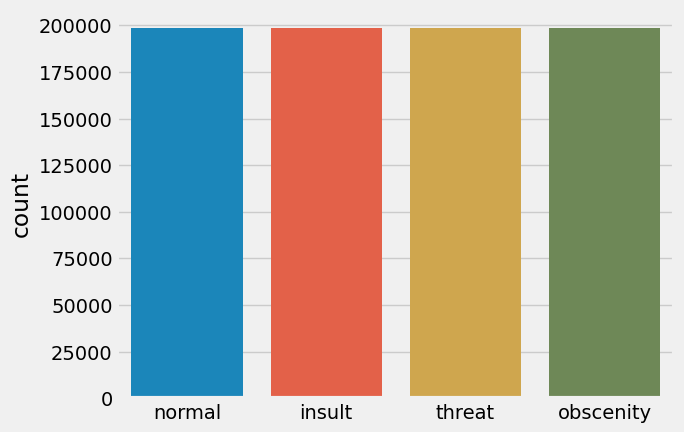

In [45]:
sns.countplot(data = df_train)

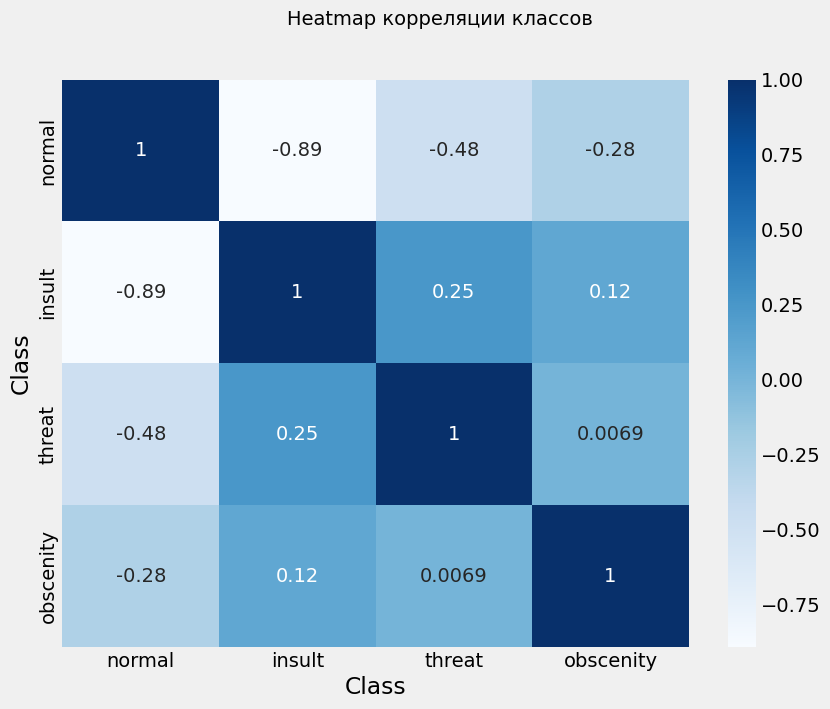

In [50]:
# heatmap for training data
fig = plt.figure(figsize = (9,7))
sns.heatmap(df_train.drop('comment_res', axis=1).corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap корреляции классов',size = 14)
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

C:\Users\erikf\AppData\Local\Temp\ipykernel_24824\3079064036.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


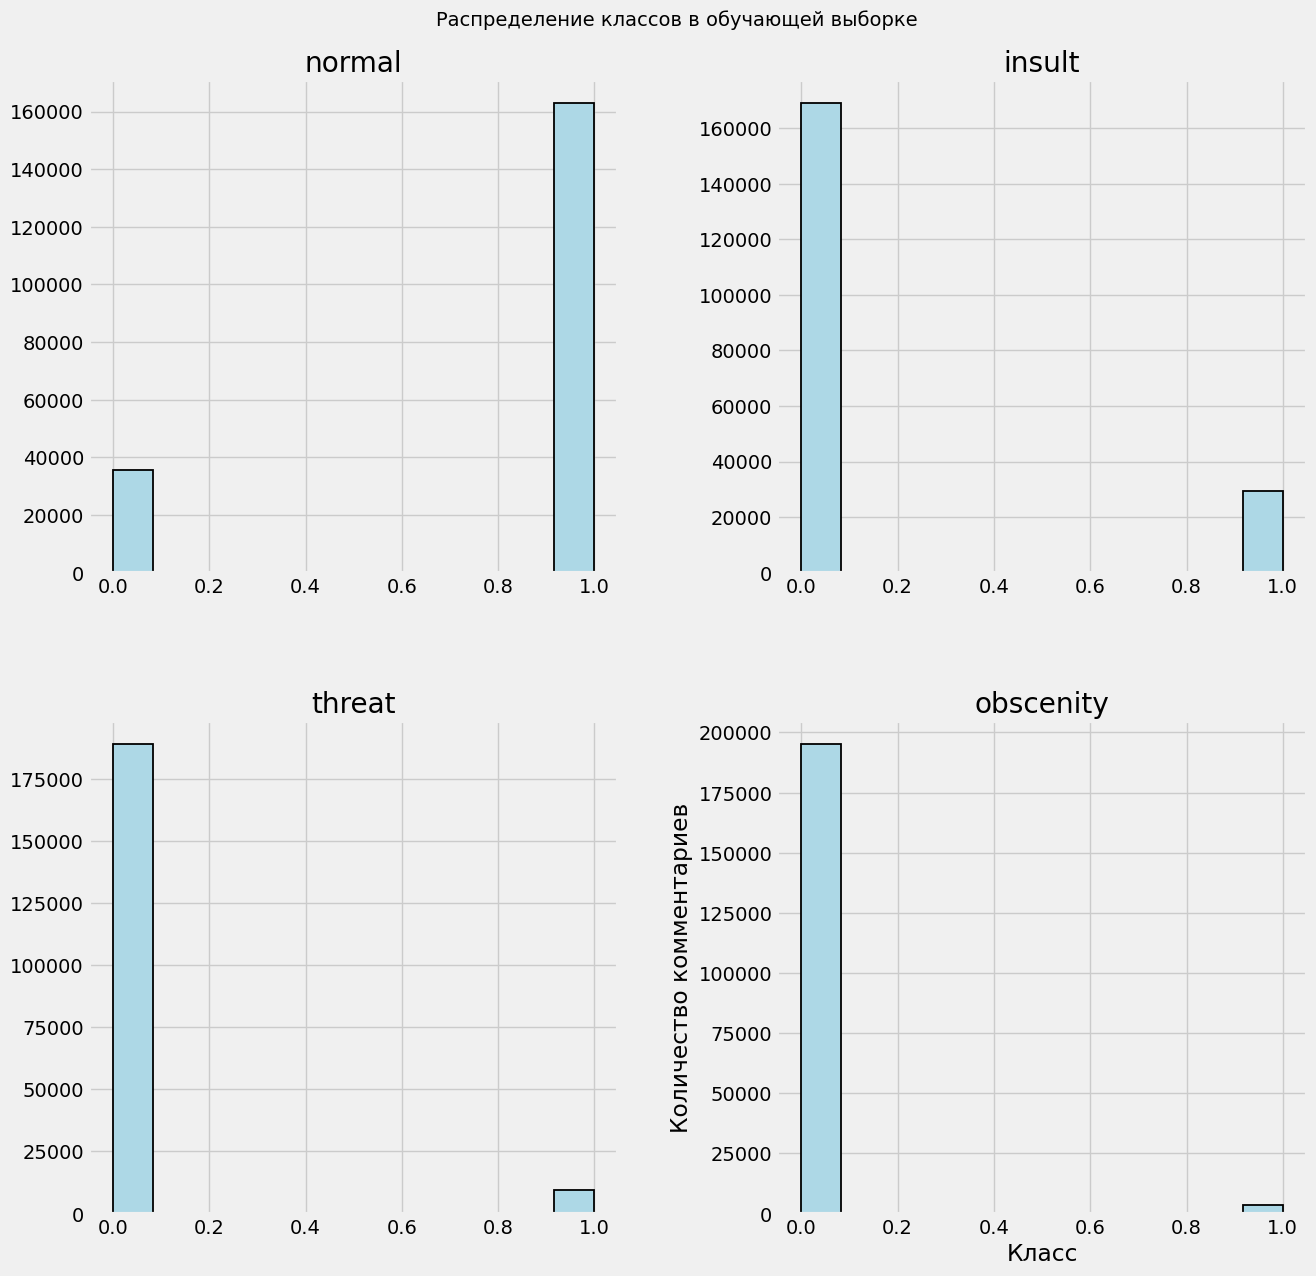

In [51]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
df_train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Распределение классов в обучающей выборке',y = 0.93,size = 14)
plt.xlabel("Класс")
plt.ylabel("Количество комментариев")
plt.show()

# Заключение